<a href="https://colab.research.google.com/github/DSNortsev/TensorFlow/blob/master/Functional_API_wide_deep_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Useful link:

https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4

https://arxiv.org/abs/1606.07792


## Tasks:
* Understand embeddings and how to create them with the feature column API
* Understand Deep and Wide models and when to use them
* Understand the Keras functional API and how to build a deep and wide model with it



In [1]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.3 || pip install tensorflow==2.3

     |████████████████████████████████| 320.4MB 42kB/s 
     |████████████████████████████████| 460kB 41.2MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
# Importing necessary modules/libraries such as numpy, pandas and datetime.
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow import feature_column as fc

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, DenseFeatures, concatenate)
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

2.3.0


In [4]:
# It sets the backend of matplotlib to the 'inline' backend. The output of plotting commands is displayed inline within frontends, directly
# below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
%matplotlib inline

In [6]:
!ls -l *.csv

-rw-r--r-- 1 root root 123590 Apr 20 03:52 taxi-test.csv
-rw-r--r-- 1 root root 579055 Apr 20 03:52 taxi-train.csv
-rw-r--r-- 1 root root 123114 Apr 20 03:52 taxi-valid.csv


In [7]:
# Selecting specific CSV_COLUMNS, LABEL_COLUMN, DEFAULTS, UNWANTED_COLS.
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


# Create an input function reading a file using the Dataset API
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
        
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


# Reading CSV files into a dataset.
def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)
    
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Feature columns for Wide and Deep model

For the Wide columns, we will create feature columns of crossed features. To do this, we'll create a collection of Tensorflow feature columns to pass to the `tf.feature_column.crossed_column` constructor. The Deep columns will consist of numeric columns and the embedding columns we want to create. 

In [62]:
# 1. Bucketize latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

fc_bucketized_plat = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_plon = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_dlat = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_longitude"), boundaries=lonbuckets)
fc_bucketized_dlon = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_latitude"), boundaries=latbuckets)

# 2. Cross features for locations
fc_crossed_dloc = fc.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_ploc = fc.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_pd_pair = fc.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

# # 3. Create embedding columns for the crossed columns
# fc_pd_pair = fc.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
# fc_dloc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
# fc_ploc = fc.embedding_column(categorical_column=fc_crossed_ploc, dimension=3)

## Example:

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow import feature_column
from tensorflow.keras import layers

In [16]:
data = {'marks': [55,21,63,88,74,54,95,41,84,52],
        'grade': ['average','poor','average','good','good','average','good','average','good','average'],
        'point': ['c','f','c+','b+','b','c','a','d+','b+','c']}

In [22]:
df = pd.DataFrame(data)
df

,marks,grade,point
0,55,average,c
1,21,poor,f
2,63,average,c+
3,88,good,b+
4,74,good,b
5,54,average,c
6,95,good,a
7,41,average,d+
8,84,good,b+
9,52,average,c


### Numeric columns

In [27]:
# A utility method to show transromation from feature column
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(data).numpy())

In [28]:
marks = feature_column.numeric_column("marks")
demo(marks)

[[55.]
 [21.]
 [63.]
 [88.]
 [74.]
 [54.]
 [95.]
 [41.]
 [84.]
 [52.]]


### Bucketized columns

In [29]:
marks_buckets = feature_column.bucketized_column(marks, boundaries=[30,40,50,60,70,80,90])
demo(marks_buckets)

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


### Categorical Columns

Indicator and embedding columns

In [43]:
grade = feature_column.categorical_column_with_vocabulary_list(
      'grade', ['poor', 'average', 'good'])
grade_one_hot = feature_column.indicator_column(grade)
demo(grade_one_hot)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


### Hashed feature columns

In [31]:
point_hashed = feature_column.categorical_column_with_hash_bucket(
      'point', hash_bucket_size=4)
demo(feature_column.indicator_column(point_hashed))

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### Crossed feature columns

In [45]:
crossed_feature = feature_column.crossed_column([marks_buckets, grade], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [34]:
demo(marks_buckets)

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


### Point column as embedding_column

In [52]:
df['point'].unique()

array(['c', 'f', 'c+', 'b+', 'b', 'a', 'd+'], dtype=object)

In [51]:
point = feature_column.categorical_column_with_vocabulary_list(
 'point', df['point'].unique())
point_one_hot = feature_column.indicator_column(point)
demo(point_one_hot)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [61]:
# Notice the input to the embedding column is the categorical column
# we previously created
point_embedding = feature_column.embedding_column(point, dimension=4)
demo(point_embedding)

[[-0.37177014  0.57047707 -0.37011644 -0.15891144]
 [-0.10197097  0.17196073 -0.26702294  0.6620817 ]
 [ 0.02254871  0.15997678  0.131773    0.7517294 ]
 [ 0.00913978 -0.5549619  -0.17353259  0.23846406]
 [ 0.29508775  0.24964562  0.3628078  -0.14540131]
 [-0.37177014  0.57047707 -0.37011644 -0.15891144]
 [ 0.7549507  -0.09860963  0.47337073 -0.45320833]
 [ 0.12721735  0.50448644 -0.67819166 -0.3631153 ]
 [ 0.00913978 -0.5549619  -0.17353259  0.23846406]
 [-0.37177014  0.57047707 -0.37011644 -0.15891144]]


In [60]:
point_embedding2 = feature_column.embedding_column(point_embedding, dimension=3)
demo(point_embedding2)

AttributeError: ignored

In [48]:
df['point'].unique()

array(['c', 'f', 'c+', 'b+', 'b', 'a', 'd+'], dtype=object)

### Gather list of feature columns

Next we gather the list of wide and deep feature columns we'll pass to our Wide & Deep model in Tensorflow. Recall, wide columns are sparse, have linear relationship with the output while continuous columns are deep, have a complex relationship with the output. We will use our previously bucketized columns to collect crossed feature columns and sparse feature columns for our wide columns, and embedding feature columns and numeric features columns for the deep columns.

In [63]:
wide_columns = [
    # One-hot encoded feature crosses
    fc.indicator_column(fc_crossed_dloc),
    fc.indicator_column(fc_crossed_ploc),
    fc.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding_column to "group" together ...
    fc.embedding_column(fc_crossed_pd_pair, dimension=10),

    # Numeric columns
    fc.numeric_column("pickup_latitude"),
    fc.numeric_column("pickup_longitude"),
    fc.numeric_column("dropoff_longitude"),
    fc.numeric_column("dropoff_latitude")
]

## Build a Wide and Deep model in Keras

To build a wide-and-deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here’s that model architecture looks using the Functional API.

First, we'll create our input columns using [tf.keras.layers.Input](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Input).

In [66]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS
}

In [70]:
inputs.values()

dict_values([<tf.Tensor 'pickup_longitude_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'pickup_latitude_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'dropoff_longitude_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'dropoff_latitude_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'passenger_count_1:0' shape=(None,) dtype=float32>])

In [68]:
# Here, tf.reduce_mean computes the mean of elements across dimensions of a tensor.
# tf.sqrt Computes element-wise square root of the input tensor.
# tf.square computes square of x element-wise.
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_model(dnn_hidden_units):
    # Create the deep part of model
    deep = DenseFeatures(deep_columns, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 

    # Create the wide part of model
    wide = DenseFeatures(wide_columns, name='wide_inputs')(inputs)

    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined')

    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation=None, name='prediction')(combined)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

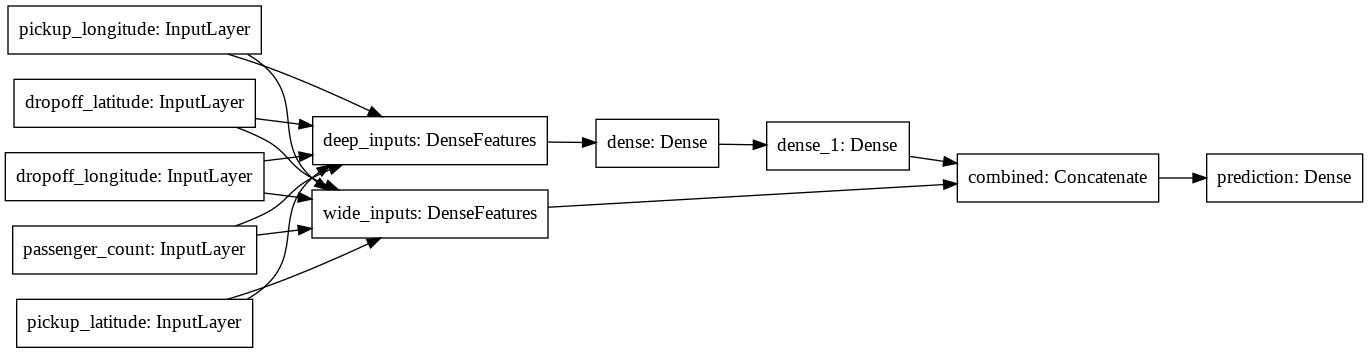

In [69]:
HIDDEN_UNITS = [10,10]

# Calling the build model
model = build_model(dnn_hidden_units=HIDDEN_UNITS)

# Converts a Keras plot_model to see a diagram of the model that we have created.
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

In [72]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='taxi-train*',
    batch_size=BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='taxi-valid*',
    batch_size=BATCH_SIZE,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

In [73]:
%%time
# Here, %%time prints the wall time for the entire cell
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True) # start fresh each time

history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(OUTDIR)])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 250.4786 - rmse: 15.8265 - mse: 250.4786 - val_loss: 248.2497 - val_rmse: 15.7467 - val_mse: 248.2497
Epoch 2/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 2s 2s/step - loss: 186.3663 - rmse: 13.6516 - mse: 186.3663 - val_loss: 244.4543 - val_rmse: 15.6253 - val_mse: 244.4543
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 258.5067 - rmse: 16.0781 - mse: 258.5067 - val_loss: 246.9424 - val_rmse: 15.7050 - val_mse: 246.9424
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 201.8834 - rmse: 14.2086 - mse: 201.8834 - val_loss: 240.3787 - val_rmse: 15.4893 - val_mse: 240.3787
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 213.7142 - rmse: 14.6190 - mse: 213.7142 - val_loss: 240.9305 - val_rmse: 15.5133 - val_mse: 240.9305
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 220.

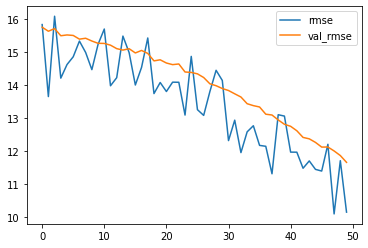

In [74]:
RMSE_COLS = ['rmse', 'val_rmse']

# Pandas DataFrame is two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).
pd.DataFrame(history.history)[RMSE_COLS].plot()